In [1]:
import plotnine as p9
import polars as pl
from p9customtheme import custom_discrete, custom_theme

from cstbioinfo.immune.utils import get_oas

# Download a example dataset from OAS
url1 = "https://opig.stats.ox.ac.uk/webapps/ngsdb/paired/Alsoiussi_2020/csv/SRR11528761_paired.csv.gz"
df1 = get_oas(url1)


url2 = "https://opig.stats.ox.ac.uk/webapps/ngsdb/paired/Alsoiussi_2020/csv/SRR11528762_paired.csv.gz"
df2 = get_oas(url2)

In [2]:
from cstbioinfo.immune import ruzicka_similarity

df1 = df1.with_columns(pl.lit("SRR11528761").alias("sample_id"))
df2 = df2.with_columns(pl.lit("SRR11528762").alias("sample_id"))
df_combined = pl.concat([df1, df2], how="vertical")

print(f"Combined DataFrame shape: {df_combined.shape}")

Combined DataFrame shape: (11388, 195)


In [3]:
df_count = df_combined.group_by(
    ["sample_id", "v_call_heavy", "j_call_heavy", "junction_aa_heavy"]
).agg(pl.len().alias("count"))
df_count.head(2)

sample_id,v_call_heavy,j_call_heavy,junction_aa_heavy,count
str,str,str,str,u32
"""SRR11528762""","""IGHV9-3*01""","""IGHJ3*01""","""CARKTAQATYWFAYW""",12
"""SRR11528761""","""IGHV1-82*01""","""IGHJ2*01""","""CARTDGYYPLLDYW""",127


In [4]:
ruzicka_similarity(
    df_count,
    feature_columns=["v_call_heavy", "j_call_heavy", "junction_aa_heavy"],
    count_column="count",
    sample_column="sample_id",
)

Calculating Ruzicka similarity: 100%|██████████| 1/1 [00:00<00:00, 161.27it/s]


sample_1,sample_2,similarity
str,str,f64
"""SRR11528761""","""SRR11528761""",1.0
"""SRR11528762""","""SRR11528762""",1.0
"""SRR11528761""","""SRR11528762""",0.905622
"""SRR11528762""","""SRR11528761""",0.905622


## Bigger test with a larger dataset



In [5]:
from tqdm import tqdm

urls = open("./data/Bashford_2013.txt").read().splitlines()

dfs = [get_oas(url) for url in tqdm(urls)]

100%|██████████| 69/69 [00:44<00:00,  1.54it/s]


In [6]:
bashford_df = pl.concat(dfs, how="vertical")
print(f"Bashford DataFrame shape: {bashford_df.shape}")

Bashford DataFrame shape: (258164, 112)


In [ ]:
df_count = bashford_df.group_by(["Run", "v_call", "j_call", "junction_aa"]).agg(
    pl.len().alias("count")
)
df_count.head(2)

Run,v_call,j_call,junction_aa,count
str,str,str,str,u32
"""ERR220446""","""IGHV5-51*01""","""IGHJ4*02""","""CARLRVTATYYFDYW""",1
"""ERR220445""","""IGHV4-61*08""","""IGHJ3*02""","""CARRRSSPDDAFDIV""",1


In [20]:
bashford_similarity = ruzicka_similarity(
    df_count,
    feature_columns=["v_call", "j_call", "junction_aa"],
    count_column="count",
    sample_column="Run",
    top_n=1000,
)

Calculating Ruzicka similarity: 100%|██████████| 2346/2346 [00:20<00:00, 112.85it/s]


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol


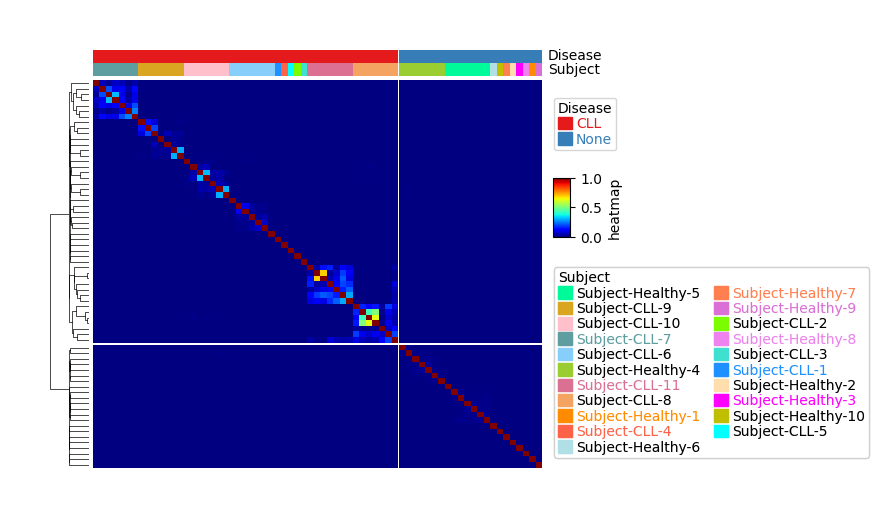

In [ ]:
import PyComplexHeatmap as pch

metadata = bashford_df.select(["Disease", "Subject", "Run"]).unique().to_pandas()
metadata.set_index("Run", inplace=True)

column_annotation = pch.HeatmapAnnotation(df=metadata)

similarity_matrix = (
    bashford_similarity.pivot(index=["sample_1"], on="sample_2", values="similarity")
    .fill_null(0)
    .to_pandas()
)
similarity_matrix = similarity_matrix.set_index("sample_1")

cm = pch.ClusterMapPlotter(
    data=similarity_matrix,
    top_annotation=column_annotation,
    row_dendrogram=True,
    legend_width=70,
    col_split=metadata["Disease"],
    row_split=metadata["Disease"],
)